In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import random

In [28]:
def weight_init(experts,opening,method, tickers):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w.astype('float64')
    
    if method == 'marketcap':
        caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
        w = []
        for ticker in tickers:
            try:
                w.append(caps_dict[ticker])
            except:
                w.append(0)
        w = np.array(w)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0    
        return np.array(w).astype('float64')

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return ((closing-opening)<0).astype('float64')    
    else:
        print("Invalid method.")

In [31]:
def rwma(filename,lossmethod,weightmethod):
    #data is an N by T array with returns for each expert/stock i in time t forming a row
    #data = np.array(data)
    #data = totalassetdata
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = [name[:name.find('_')] for name in opening.columns]
    dates = opening.index.values
    #print(dates)
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,weightmethod, tickers)
   
    p = w/sum(w)
    
    start = 10000000
    
    #M = np.zeros(N)
    #M_wma_random = 0
    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    #allweights = []

    # iterations
    for t in range(T):
               
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        opening_prices = opening.iloc[t].values
        opening_prices[opening.iloc[t].isnull()] = 0
        if 0 not in opening_prices and weightmethod=='equal' and 0 in w:
            w[w==0] = 1
        elif 0 not in opening_prices and weightmethod=='marketcap' and 0 in w:
            caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
            wt = []
            for ticker in np.array(tickers)[w==0]:
                try:
                    wt.append(caps_dict[ticker])
                except:
                    wt.append(0)
            w[w==0] = wt
        #closing_prices_na = closing.iloc[t]
        closing_prices = closing.iloc[t].values
        closing_prices[closing.iloc[t].isnull()] = 0
        #return opening_prices
        
        #portfolio value
        if t==0: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                #print(p[j],type(p[j]),values[t],type(values[t]),k,type(k))
                # TODO - fix true divide error
                try:
                    q_t.append((p[j]*values[t])/k)
                except:
                    q_t.append(0)
            else:
                q_t.append(0)
        quantities.append(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod) 
        loss[np.isnan(loss)] = 0
                
        #check sum of weight updates
        #money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        money_moved = sum(np.absolute([p[i]*((1-epsilon)**loss[i]-1) for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1 - epsilon)**loss[i]
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
       
        p = w/sum(w)
        probs.append(p)
        #return p
    
    out = pd.DataFrame(probs[1:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'rwma_weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction %: ',len(transaction)/T*100,'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    print('Return',((values[-1]-sum([v[1] for v in transaction]))-start)/start*100,'%')
    plt.plot(values)
    plt.show()
    return values

In [47]:
filename = 'highvol_hourly.xlsx'

Final distribution:  [0.04089959 0.06309637 0.03750265 0.06309637 0.05785586 0.10615657
 0.02043913 0.02651146 0.04864443 0.15016724 0.03153173 0.04089959
 0.04864443 0.05305059 0.15016724 0.00936588 0.02043913 0.03153173]
Final transaction %:  44.39140811455847 total cost:  1076517.135295526
starting value:  10000000 final value:  10630645.271892244 less transaction costs:  9554128.136596719
Return -4.458718634032812 %


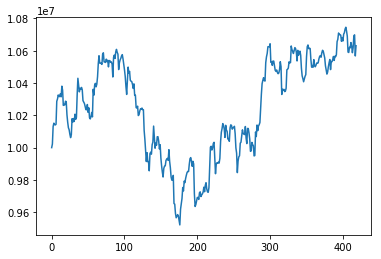

[10000000,
 10022293.842267282,
 10130170.052427385,
 10151307.843288787,
 10142576.115555542,
 10140444.341455568,
 10144371.58237413,
 10286727.89819804,
 10301122.588390933,
 10325786.349614982,
 10316407.014336184,
 10315993.81705959,
 10333526.594615007,
 10314505.235655874,
 10380377.362820327,
 10355496.51627585,
 10261331.666202566,
 10267528.894529259,
 10264248.536695853,
 10287220.876767667,
 10284510.260676147,
 10203305.51127966,
 10157143.14743732,
 10122869.782918647,
 10110824.766204825,
 10082616.654633926,
 10061962.822528508,
 10079744.02907753,
 10178886.052848766,
 10157411.925313598,
 10180027.39928685,
 10161996.101236857,
 10206947.842160296,
 10175251.690536998,
 10187511.982873036,
 10323879.729535652,
 10429151.241025198,
 10387690.275641834,
 10345187.829418706,
 10367550.44925056,
 10360348.958177418,
 10372488.094345871,
 10357888.533516826,
 10290947.907450536,
 10281862.571272768,
 10273092.20655773,
 10253093.333569504,
 10235294.536946615,
 10234493.16

In [48]:
rwma(filename,'absolute','equal')

Final distribution:  [4.27465827e-05 9.98864197e-01 1.36018063e-04 1.53684047e-05
 9.26970743e-06 3.65000167e-04 1.10417382e-05 1.78458407e-05
 8.29969804e-06 8.95171902e-05 1.83968114e-05 5.35081375e-05
 3.53466365e-06 2.98198440e-04 3.98404894e-05 2.77283112e-06
 8.78251621e-06 1.56613794e-05]
Final transaction %:  43.198090692124104 total cost:  779469.4776488729
starting value:  10000000 final value:  11234021.895967837 less transaction costs:  10454552.418318965
Return 4.545524183189645 %


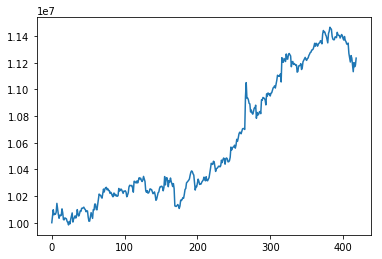

[10000000,
 10051299.737176929,
 10097074.296189869,
 10059184.777779194,
 10066714.202002455,
 10063087.808078513,
 10078475.271600801,
 10144955.509699095,
 10101925.203808228,
 10062246.500955021,
 10033172.749443002,
 10056856.480000742,
 10052836.909323493,
 10054659.722589413,
 10103735.369204605,
 10074556.56306831,
 10023377.109210037,
 10021436.978769127,
 10036361.219444523,
 10032182.363485727,
 10029997.547407147,
 10010714.251133082,
 10000786.800490748,
 9983339.297534168,
 10008975.059146665,
 9991802.609225014,
 10025853.292261861,
 10048965.169006668,
 10073280.608555295,
 10004664.502360929,
 10028274.29808613,
 10037916.406841557,
 10051313.48920611,
 10034873.410860652,
 10048783.600450007,
 10098140.838328362,
 10063794.456487488,
 10050186.374892429,
 10065237.61299529,
 10088358.261784762,
 10084523.057922898,
 10108056.934174929,
 10107187.313072879,
 10112351.243462833,
 10116405.742089728,
 10103277.118844304,
 10099947.04022038,
 10082215.785186138,
 10086834

In [49]:
rwma(filename,'absolute','marketcap')